In [75]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.optim as optim
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
from tensorflow.keras import layers, models
import torch
import numpy as np
import math

# Load dataset
data = fetch_california_housing()
X, y = data.data, data.target  # Features and target

# Shuffle and split data
X, y = np.random.permutation(X), np.random.permutation(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [76]:
#created the calibration set and the proper training set
X_cal = X_train[-1000:]
y_cal = y_train[-1000:]
X_proper_train = X_train[:-1000]
y_proper_train = y_train[:-1000]

X_proper_train = torch.tensor(X_proper_train, dtype=torch.float32)
y_proper_train = torch.tensor(y_proper_train, dtype=torch.float32).view(-1, 1)

X_cal = torch.tensor(X_cal, dtype=torch.float32)
y_cal = torch.tensor(y_cal, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [77]:
def quantile_loss(y_pred, y_true, tau):
    errors = y_true - y_pred
    return torch.mean(torch.max(tau * errors, (tau - 1) * errors))


In [78]:
# Model parameters: Weight and Bias
def get_coverage_quantile_regression(alpha):
    input_dim = X_proper_train.shape[1]
    W_lower = torch.randn((input_dim, 1), requires_grad=True, dtype=torch.float32)
    b_lower = torch.zeros(1, requires_grad=True, dtype=torch.float32)

    W_upper = torch.randn((input_dim, 1), requires_grad=True, dtype=torch.float32)
    b_upper = torch.zeros(1, requires_grad=True, dtype=torch.float32)

    # Hyperparameters
    taus = [alpha / 2, 1 - alpha / 2]  # Lower and Upper Quantiles
    epochs = 500
    lr = 0.01

    # Optimizers
    opt_lower = optim.Adam([W_lower, b_lower], lr=lr)
    opt_upper = optim.Adam([W_upper, b_upper], lr=lr)

    for epoch in range(epochs):
        # Lower Quantile Model (tau = alpha/2)
        opt_lower.zero_grad()
        y_pred_lower = torch.matmul(X_proper_train, W_lower) + b_lower
        loss_lower = quantile_loss(y_pred_lower, y_proper_train, taus[0])
        loss_lower.backward()
        opt_lower.step()

        # Upper Quantile Model (tau = 1-alpha/2)
        opt_upper.zero_grad()
        y_pred_upper = torch.matmul(X_proper_train, W_upper) + b_upper
        loss_upper = quantile_loss(y_pred_upper, y_proper_train, taus[1])
        loss_upper.backward()
        opt_upper.step()

    y_lower_pred = torch.matmul(X_cal, W_lower).detach()
    y_upper_pred = torch.matmul(X_cal, W_upper).detach()

    score_array = torch.maximum(y_lower_pred - y_cal, y_cal - y_upper_pred)
    # Compute the quantile index
    import math
    n = score_array.shape[0]
    quantile_index = math.ceil((n + 1) * (1 - alpha)) / n

    # Compute the required quantile
    q_hat = torch.quantile(score_array, quantile_index)
    y_lower_pred_test = torch.matmul(torch.tensor(X_test, dtype=torch.float32), W_lower).detach()
    y_upper_pred_test = torch.matmul(torch.tensor(X_test, dtype=torch.float32), W_upper).detach()


    covered = (y_test >= (y_lower_pred_test - q_hat)) & (y_test <= (y_upper_pred_test + q_hat))

    coverage_percentage = covered.float().mean().item() * 100

    return coverage_percentage



In [79]:
get_coverage_quantile_regression(0.1)

/tmp/ipykernel_3083158/2370866926.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_lower_pred_test = torch.matmul(torch.tensor(X_test, dtype=torch.float32), W_lower).detach()
/tmp/ipykernel_3083158/2370866926.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_upper_pred_test = torch.matmul(torch.tensor(X_test, dtype=torch.float32), W_upper).detach()


91.54554009437561

### Uncertainty Estimate Method

In [80]:
def get_coverage_uncertainty_model(alpha):
    def build_point_predictor(input_shape):
        model = models.Sequential()
        model.add(layers.InputLayer(input_shape=(input_shape,)))  # Correct input shape as a tuple
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dense(1))  # Output layer for regression (point prediction)
        model.compile(optimizer='adam', loss='mse')
        return model

    # Define the Uncertainty Predictor Model (Residual Model)
    def build_uncertainty_predictor(input_shape):
        model = models.Sequential()
        model.add(layers.InputLayer(input_shape=(input_shape,)))  # Correct input shape as a tuple
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dense(1))  # Output layer for estimating the uncertainty (residual)
        model.compile(optimizer='adam', loss='mse')
        return model

    # Build Point Predictor Model
    point_model = build_point_predictor(X_proper_train.shape[1])  # Correct shape usage
    point_model.fit(X_proper_train, y_proper_train, epochs=50, batch_size=16, verbose=0)

    # Get the Point Predictions
    y_hat_train = point_model.predict(X_proper_train)

    residuals_train = abs(y_proper_train - y_hat_train)

    uncertainty_model = build_uncertainty_predictor(X_proper_train.shape[1])  # Correct shape usage
    uncertainty_model.fit(X_proper_train, residuals_train, epochs=50, batch_size=16, verbose=0)

    #get scores for calibration data set
    y_hat_calib = point_model.predict(X_cal)
    residuals_calib = abs(y_cal - y_hat_calib)
    uncertainty_scores = uncertainty_model.predict(X_cal)

    scores = np.divide(residuals_calib, uncertainty_scores)
    n = scores.shape[0]
    quantile_index = math.ceil((n + 1) * (1 - alpha)) / n
    q_hat = np.quantile(scores, quantile_index)
    y_hat_test = point_model.predict(X_test)
    uncertainty_scores_test = uncertainty_model.predict(X_test)
    y_test_t = y_test.numpy()
    covered = (y_test_t >= (y_hat_test - q_hat * uncertainty_scores_test)) & (y_test_t <= (y_hat_test + q_hat * uncertainty_scores_test))
    coverage_percentage = covered.mean() * 100
    return coverage_percentage
    


In [81]:
get_coverage_uncertainty_model(0.5)

/home/adithyakanil/myenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/tmp/ipykernel_3083158/3115677728.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals_train = abs(y_proper_train - y_hat_train)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
  1/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

/tmp/ipykernel_3083158/3115677728.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals_calib = abs(y_cal - y_hat_calib)
/tmp/ipykernel_3083158/3115677728.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scores = np.divide(residuals_calib, uncertainty_scores)


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


np.float64(47.89244186046512)

In [82]:
import xgboost as xgb
import numpy as np
import math

def get_coverage_xgboost(alpha):
    # Train an XGBoost model for Point Prediction
    def build_point_predictor():
        model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1)
        return model

    # Train the Point Predictor Model
    point_model = build_point_predictor()
    point_model.fit(X_proper_train, y_proper_train)

    # Get the Point Predictions
    y_hat_train = point_model.predict(X_proper_train)

    # Calculate residuals (absolute difference between predicted and true values)
    residuals_train = np.abs(y_proper_train - y_hat_train)

    # For Uncertainty estimation: We use the leaf variance from the trees in XGBoost
    leaf_preds_train = point_model.apply(X_proper_train)  # Get the leaf indices for each sample
    uncertainty_scores = np.std(leaf_preds_train, axis=1)  # Standard deviation of the leaf predictions

    # Train on Calibration Data
    y_hat_calib = point_model.predict(X_cal)
    residuals_calib = np.abs(y_cal - y_hat_calib)
    leaf_preds_calib = point_model.apply(X_cal)
    uncertainty_scores_calib = np.std(leaf_preds_calib, axis=1)

    # Calculate scores and quantile for uncertainty adjustment
    scores = np.divide(residuals_calib, uncertainty_scores_calib)
    n = scores.shape[0]
    quantile_index = math.ceil((n + 1) * (1 - alpha)) / n
    q_hat = np.quantile(scores, quantile_index)

    # Get Predictions for Test Data
    y_hat_test = point_model.predict(X_test)
    leaf_preds_test = point_model.apply(X_test)
    uncertainty_scores_test = np.std(leaf_preds_test, axis=1)

    # Calculate coverage
    lower_bound = y_hat_test - q_hat * uncertainty_scores_test
    upper_bound = y_hat_test + q_hat * uncertainty_scores_test
    covered = (y_test.numpy() >= lower_bound) & (y_test.numpy() <= upper_bound)
    coverage_percentage = covered.mean() * 100

    return coverage_percentage


In [83]:
get_coverage_xgboost(0.5)

/tmp/ipykernel_3083158/3619048939.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals_train = np.abs(y_proper_train - y_hat_train)
/tmp/ipykernel_3083158/3619048939.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals_calib = np.abs(y_cal - y_hat_calib)
/tmp/ipykernel_3083158/3619048939.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scores = np.divide(residuals_calib, uncertainty_scores_calib)


np.float64(47.07396852089718)

### Jackknife, Jackknife+ Method - Full Conformal Prediction

In [84]:
#append an extra 1 to the end of the training and test set so that we don't have to deal with the bias term
X_train_bias = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
y_test_cpy = y_test.numpy()

A = X_train_bias.T @ X_train_bias            # X^T X
A_inv = np.linalg.inv(A)                     # (X^T X)^-1
w = A_inv @ X_train_bias.T @ y_train         # (X^T X)^-1 X^T y


In [85]:

score_array = np.array([0.0]*X_train_bias.shape[0])
for i in range(len(X_train_bias)):
	x = X_train_bias[i]
	y = y_train[i]
	x = x.reshape(1, -1)
	numerator = A_inv @ x.T @ x@A_inv
	denominator = 1-x@A_inv @ x.T
	if(denominator == 0):
		y_pred = x @ w
		score_array[i] = abs(y_pred - y)
	else:
		A_inv_new = A_inv + numerator/denominator
		w_new = w - A_inv_new @ x.T @ (y - x @ w)
		y_pred = x @ w_new
		score_array[i] = abs(y_pred - y)


/tmp/ipykernel_3083158/3612288799.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score_array[i] = abs(y_pred - y)


Refer to Sherman-Morrison Update to add and remove efficiently in Linear Regression

In [86]:
def getCvgJackknife(alpha):	
	index = math.ceil((len(score_array) + 1) * (1 - alpha)) / len(score_array)
	q_hat = np.quantile(score_array, index)


	y_test_pred = X_test_bias @ w
	coverage = (y_test_cpy >= (y_test_pred - q_hat)) & (y_test_cpy <= (y_test_pred + q_hat))
	coverage_percentage = coverage.mean() * 100
	
	return coverage_percentage

In [87]:
def getCvgJackknife_plus(alpha):
	score_dict = [[] for i in range(len(X_test_bias))]
	for i in range(len(X_train_bias)):
		x = X_train_bias[i]
		y = y_train[i]
		x = x.reshape(1, -1)
		denominator = 1-x@A_inv @ x.T
		if(denominator == 0):
			w_new = w
		else:
			numerator = A_inv @ x.T @ x@A_inv
			A_inv_new = A_inv + numerator/denominator
			w_new = w - A_inv_new @ x.T @ (y - x @ w)
		
		for j in range(len(X_test_bias)):
			score_dict[j].append(abs(X_test_bias[j] @w_new - score_array[i]))

	#calculate coverage
	coverage = 0
	for i in range(len(X_test_bias)):
		index_up = math.ceil((len(score_dict[i]) + 1) * (1 - alpha)) / len(score_dict[i])
		index_low = math.floor((len(score_dict[i]) + 1) * (alpha)) / len(score_dict[i])
		q_lower = np.quantile(score_dict[i], index_low)
		q_upper = np.quantile(score_dict[i], index_up)
		coverage += (y_test_cpy[i] >= (X_test_bias[i] @ w - q_upper)) & (y_test_cpy[i] <= (X_test_bias[i] @ w + q_lower))
	coverage_percentage = (coverage/ len(X_test_bias)) * 100
	return coverage_percentage
			


In [89]:
getCvgJackknife_plus(0.1)

array([76.30813953])

/tmp/ipykernel_3083158/2370866926.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_lower_pred_test = torch.matmul(torch.tensor(X_test, dtype=torch.float32), W_lower).detach()
/tmp/ipykernel_3083158/2370866926.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_upper_pred_test = torch.matmul(torch.tensor(X_test, dtype=torch.float32), W_upper).detach()
/tmp/ipykernel_3083158/3619048939.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residuals_train = np.abs(y_proper_train - y_hat_train)
/tmp/ipykernel_3083158/3619048939.py:27: DeprecationWarning: __array_wrap__ must accept context and 

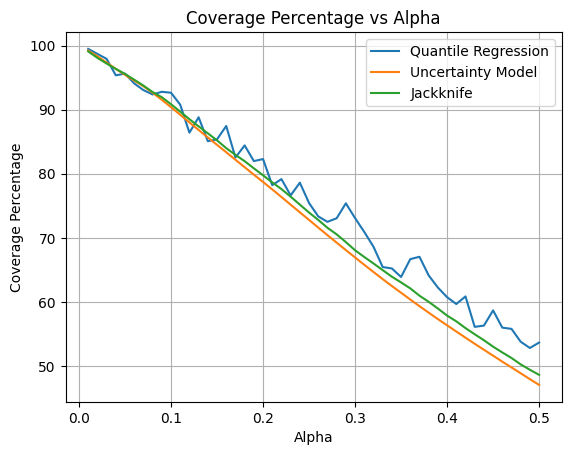

In [90]:
alpha = np.linspace(0.01, 0.50, 50)
coverage_quantile = []
coverage_xgboost = []
jackknife = []
# jackknife_plus = []

for a in alpha:
	coverage_quantile.append(get_coverage_quantile_regression(a))
	coverage_xgboost.append(get_coverage_xgboost(a))
	jackknife.append(getCvgJackknife(a))
	# jackknife_plus.append(getCvgJackknife_plus(a))
import matplotlib.pyplot as plt

plt.plot(alpha, coverage_quantile, label='Quantile Regression')
plt.plot(alpha, coverage_xgboost, label='Uncertainty Model')
plt.plot(alpha, jackknife, label='Jackknife')
# plt.plot(alpha, jackknife_plus, label='Jackknife+')

plt.xlabel('Alpha')
plt.ylabel('Coverage Percentage')
plt.title('Coverage Percentage vs Alpha')
plt.legend()
plt.grid()
plt.show()


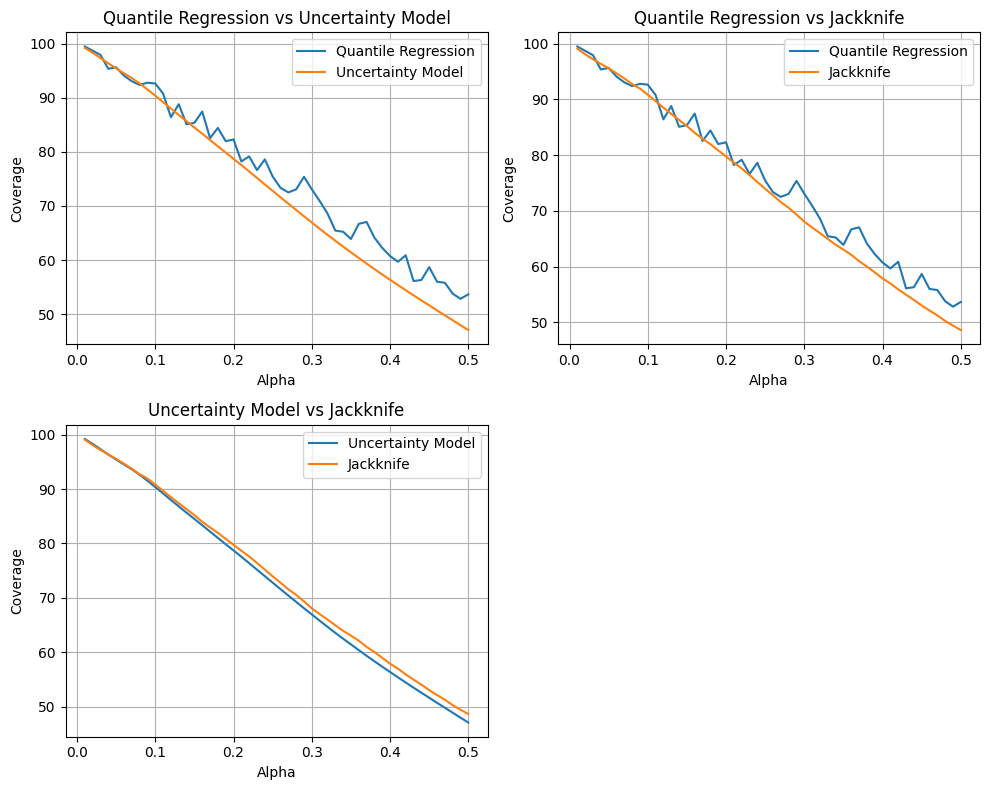

In [92]:
import matplotlib.pyplot as plt
import itertools

# Define coverage methods and labels
coverages = {
    'Quantile Regression': coverage_quantile,
    'Uncertainty Model': coverage_xgboost,
    'Jackknife': jackknife,
}

# Generate all unique pairs (excluding self-pairs)
pairs = list(itertools.combinations(coverages.items(), 2))

# Set up subplots: n rows, 2 columns
n = len(pairs)
cols = 2
rows = (n + 1) // 2

fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
axes = axes.flatten()

# Plot each pair
for ax, ((label1, data1), (label2, data2)) in zip(axes, pairs):
    ax.plot(alpha, data1, label=label1)
    ax.plot(alpha, data2, label=label2)
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Coverage")
    ax.set_title(f"{label1} vs {label2}")
    ax.legend()
    ax.grid(True)

# Hide any extra axes
for i in range(len(pairs), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()